15-688 final project - jiabinc, kailic, tingyiw
# Analysis of Pittsburgh Restaurant Reviews from Yelp

## Introduction
Yelp is a business directory service and crowd-sourced review forum. Since Yelp users usually rely heavily on ratings and reviews for restaurants, it is important for ratings on Yelp to accurately represent the quality of the restaurants. In this project, we analyzed the sentiment of restaurant reviews to compare that with the overall ratings restaurants received from users, and we focused on the differences among six popular cuisines. Moreover, since restaurant owners are interested in increasing the popularity of their restaurants, we seek important variables that contribute to higher average number of reviews of restaurants in a neighborhood.
   
   
## The content of this Project will be as the followings:
- [Getting Data](#Getting-Data)<br>
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
- [Sentimental Analysis on Reviews](#Sentimental-Analysis-on-Reviews)<br>
- [Restaurant Popularity: Number of Reviews](#Restaurant-Popularity:-Number-of-Reviews)<br>
- [Recommendations](#Recommendations)<br>
- [Future Directions](#Future-Directions)<br>
- [References](#References)<br>
<br><br>

## Getting Data

For our Project analyzing reviews of restaurants at Pittsburgh, we use yelp as our data source for further analysis.

### Approach
 - __API__ <br>
  Using [Yelp Fusion API](https://www.yelp.com/fusion), we collect the basic information of restaurants in     Pittsburgh area.
 - __Beautiful Soup__ <br>
  Reviews of restaurants are scraped from restaurant page, getting the first 5 reviews.
  
#### 1. Restaurants in Pittsburgh
Our Project focus on restaurants inside `Pittsburgh` areas under 6 popular cetagores : <br>
`Chinese`, `Newamerican`, `Mexican`, `Italian`, `Korean`, `Japanese`<br>
<br>
There are a total of 2,088 restaurants in Pittsburgh. Here we were not passing the parameters to get restaurants under certain categories because of the issue with the unstable filter of the API( ex. Adding parameters of Japanses also returned many other type of restaurants such as Italian), but we scrape the category label while scraping and process the data after we'd acquired the full restaurants data set.<br><br>
Recall that we scrape data from yelp in Homework1. We modify the home work to collect the data we needed.<br>
<br>
we'll need the following library:

In [73]:
import time, json
import requests
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup
from scipy import stats
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
matplotlib.style.use('ggplot')

Since Yelp Fusion API require API Key for access. Following function(from HW1) is to read our API key for further usage.

In [2]:
def read_api_key(filepath="api_key.txt"):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    return Path(filepath).read_text().strip()

For restaurants information, we modified our code from Homework1, but instead of returning a List, we store the data into Pandas DataFrame.<br>

For the DataFrame of the restaurant basic information, we will have 8 columns as follows:<br>

| | **restaurants** | 
|----------|:-------------|
| restId      | Restaurant identifier(the ID of the restaurant. |
| name | Name of the restaurant. |
| category | The type of restaurant (eg. NewAmerican, Chinese, Italian...)|
| rating | Overall rating of the restaurant. |
| review_count | Number of reviews the restaurant have received so far. |
| url | url to the page of the restaurant on Yelp. | 
| zipcode | The zipcode of the restaurant. | 
| address | Address of the restaurant. | 


In [3]:
def all_restaurants(api_key, query, df):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term(Locations, eg. Pittsburgh)
        
        df: DataFrame to add our restaurant info into
        
    Returns:
        results (list): list of dicts representing each business
    """
    # base url for searching with yelp API.
    base_url = "https://api.yelp.com/v3/businesses/search" 
    # parameters for our search. Here we limit our search to Restaurants.
    params = {'categories': 'Restaurants', 'location': query} 
    # headers containing our API Key
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
    res = requests.get(base_url, params = params, headers = headers)
    base_data = json.loads(res.text)
    # get the total records returned by API
    try:
        total_rec = base_data.get('total')
    except Exception as e:
        total_rec = None
        print(e)
        return []
    # calculate the pages we need to loop through for getting all the data
    total_page = int(total_rec / 20 + 1)
    # sending request to API with the parameters of offset and pages info
    for page in range(1, total_page+1):
        offset = str((page-1)*20)
        limit = str(20)
        # update the parameters
        params.update({'offset': offset, 'limit': limit})
        # request and loads the returned data
        res = requests.get(base_url, params = params, headers = headers)
        data = json.loads(res.text)
        try:
            for block in data['businesses']:
                # We use zipcode to narrow down the number of records to get full access to the total records returned
                # reason to use zipcode are explained below
                zipcode = block.get('location').get('zip_code')
                # since the filter of the API does not work as expected to narrow to only one zipcode but also 
                # include some restaurants in other zipcode. To prevent duplicated data inserted. We chech if 
                # the zipcode is already in our data. If yes, skip.
                if zipcode != query:
                    continue
                # get restaurant ID
                restId = block.get('id')
                # get restaurant name
                name = block.get('name')
                # get review count
                review_count = block.get('review_count')
                # get rating
                rating = block.get('rating')
                # we will use category to narrow down the restaurants to those we are focusing on.
                category = block.get('categories')[0].get('alias')
                # get address
                address = block.get('location').get('address1')
                # we will later use this to scrape the reviews of a restaurant.
                url = block.get('url')
                # storing data into DataFrame
                df = df.append({'restId':restId, 'name':name, 'category':category, 'rating':rating, 'review_count':review_count, 'zipcode':zipcode, 'address':address, 'url':url}, ignore_index=True)
        except KeyError:
                pass
        time.sleep(0.2)
    return df

However, since the API has a limitation of 1,000 records being returned for each request, we are not able to extract all 2,088 records by a single request. Therefore, we narrowed down the location scope for our request to break the returned data into smaller chunk. For each request, we request by a zipcode area inside Pittsburgh, thus before scraping the restaurant data, we first scrape the data of all zipcode within Pittsburgh.

We get the zipcode list of all Pennsylvania by scraping the from [ZIP CODES TO GO](https://www.zipcodestogo.com/Pennsylvania/). By the first few attempts on the scraping, the status code 406 were returned indicating the request we sent is not acceptable according to [Wikipedia-state code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes). We try to by pass this problem by generating a fake header for our request.

To generate a random header for the request, we use an external package [fake-useragent 0.1.11](https://pypi.org/project/fake-useragent/). Following function for generating random_headers are modified from the sample code from the package website(check the link above).

In [4]:
from fake_useragent import UserAgent

In [5]:
def random_headers():
    """
    generate random headers.
        
    Returns:
        results String: a header to use in our request.
    """
    try:
        # instantiate a UserAgent object
        ua = UserAgent()
    except FakeUserAgentError:
        pass
    # get a random header
    random_user_agent =ua.random
    return random_user_agent

In [6]:
def zipCodeScraper(url):
    """
    get the list of zipcode.
    
    Args:
        url (String): The String value of the target url to scrape the zipcode needed.
    Returns:
        results (List): a list of zipcode.
    """
    # include our header for the request
    headers = {
                'User-Agent':random_headers(),
            }
    response = requests.get(url, headers = headers)
    soup = BeautifulSoup(response.text, "html.parser")
    block = soup.find_all('td', {'align':'center'})
    zip_code = []
    for record in block:
        zipcode = record.text
        zip_code.append(zipcode)
    return zip_code

In [8]:
# We now gets a list of all the zipcodes within Pennsylvenia.
zipcode_list = zipCodeScraper('https://www.zipcodestogo.com/Pennsylvania/')

In [9]:
# Narrowed it down to zipcodes within Pittsburgh (zipcode start with 152)
pitts_zipcode = [i for i in zipcode_list if i[:3] == '152']

In [13]:
# Instantiate a DataFrame to store all records:
pitts_rest = pd.DataFrame()

In [14]:
for zipcode in tqdm_notebook(pitts_zipcode):
    pitts_rest = all_restaurants(red_api_key(), zipcode, pitts_rest)

Since it take more than an hour to scrape all the restaurants, we provide the csv file of the data on the [google drive](https://drive.google.com/open?id=1okbuSNMZ8qNTzyKPax5nothX9Qwv5Ul4).<br>

In [123]:
# here is our quick peek for the data.
pitts_rest = pd.read_csv("pitts_rest.csv", index_col=0)

In [66]:
pitts_rest

,address,category,name,rating,restId,review_count,url,zipcode
0,4502 Butler St,vietnamese,Banh Mi & Ti,4.5,4mYS-4UOjTKgsf0tX1_IkQ,250.0,https://www.yelp.com/biz/banh-mi-and-ti-pittsb...,15201
1,5202 Butler St,coffee,B52 Cafe,4.5,bXCWON2Me0o86qvAb-XZPQ,258.0,https://www.yelp.com/biz/b52-cafe-pittsburgh-4...,15201
2,3623 Butler St,coffee,Espresso a Mano,4.5,Cf0iV72DTqR0ggBje2d0sg,337.0,https://www.yelp.com/biz/espresso-a-mano-pitts...,15201
3,4121 Butler St,creperies,Geppetto Cafe,4.5,FG8atOE15c8IoQH_hEb9zA,242.0,https://www.yelp.com/biz/geppetto-cafe-pittsbu...,15201
4,3801 Butler St,italian,Piccolo Forno,4.0,usFNFsaaHFxEbnBO4FaFHA,447.0,https://www.yelp.com/biz/piccolo-forno-pittsbu...,15201
...,...,...,...,...,...,...,...,...
2083,250 Summit Park Dr,hotdogs,McDonald's,1.0,ev4frBEgYDHiNZPcdYAIbA,4.0,https://www.yelp.com/biz/mcdonalds-pittsburgh-...,15275
2084,362 Three Rivers Heritage Trl,localflavor,10th Street Bridge,3.5,YsoNK7NeZY4352Z9egAQhA,2.0,https://www.yelp.com/biz/10th-street-bridge-pi...,15282
2085,4200 5th Ave,collegeuniv,Cathedral of Learning,4.5,1oxMj71XiKQjCbRxECzB7w,117.0,https://www.yelp.com/biz/cathedral-of-learning...,15289
2086,1101 Bradish St,divebars,Bar 11,4.0,coQ7N18I5maP00TbNb64nA,62.0,https://www.yelp.com/biz/bar-11-pittsburgh?adj...,15289


Now that we have the basic information of 2,088 restaurants in Pittsburgh ready. We can dive into scraping the reviews from restaurants in Pittsburgh.<br>
<br>
### 2. Reviews on Restaurants
For each restaurants, we got 5 reviews from them for further sentimental analysis.

In [59]:
# First, Recall that our target data only focus on restaurants of the 6 categories. We narrow it down to what we want.
pitts_rest_cat = pitts_rest.loc[pitts_rest['category'].isin(['chinese','newamerican', 'mexican', 'italian', 'korean', 'japanese'])].sort_values('category').reset_index(drop = True)

In [63]:
# Second, we will need the url of all restaurant to scrape the reviews:
pitts_rest_url = pitts_rest_cat.loc[:, ['category', 'url', 'restId']].sort_values('category').reset_index(drop = True)

In [64]:
pitts_rest_url

,category,url,restId
0,chinese,https://www.yelp.com/biz/amazing-wok-pittsburg...,fjE-jiwnTQysz-rLl6YMQg
1,chinese,https://www.yelp.com/biz/tongs-cuisine-pittsbu...,LLGGe9k7NTVy1Z2wH1_Uew
2,chinese,https://www.yelp.com/biz/ya-fei-pittsburgh-3?a...,iuIkzvQRb4DVWOMhE4GI3g
3,chinese,https://www.yelp.com/biz/china-taste-pittsburg...,O5MzWfMWDeEwkzNVeKdCfg
4,chinese,https://www.yelp.com/biz/yeungs-house-pittsbur...,qThJY-H6Fo8HvfdIvwrjiw
...,...,...,...
309,newamerican,https://www.yelp.com/biz/vue-412-pittsburgh?ad...,hF1-dtY_oXfngC8h2mY4qg
310,newamerican,https://www.yelp.com/biz/altius-pittsburgh?adj...,S8urdN6ACnRQUm-7o9An8w
311,newamerican,https://www.yelp.com/biz/murray-avenue-grill-p...,kT9SuRVTapbDgFGMcg1Rqg
312,newamerican,https://www.yelp.com/biz/silk-road-gourmet-chi...,1MrJJ9tyNyfFrxaNZ67xFg


In [27]:
# We than turn this data into a list of tuples that each tuple contains the three information so we can loop through it to get the url to scrape the reviews.
info_list = [(row[0], row[1], row[2]) for row in pitts_rest_url.values]

In [31]:
# The structure of each tuple would look like the following example.
info_list[0]

('chinese',
 'https://www.yelp.com/biz/amazing-wok-pittsburgh?adjust_creative=E2BH6jna89195oC1_AjHXw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=E2BH6jna89195oC1_AjHXw',
 'fjE-jiwnTQysz-rLl6YMQg')

Here we modified the previous code of HW1 and again store our data into a new DataFrame.

In [26]:
def extract_reviews(info_list, df):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.
        df (DataFrame): a DataFrame to store the records

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """
    response = requests.get(info_list[1])
    soup = BeautifulSoup(response.text, "html.parser")
    block = soup.find_all('div', {'itemprop':'review'})
    # We only want to get the first 5 records of the reviews
    # First check if the restaurant have more than five reviews
    if len(block) >= 5:
        for record in block[:5]:
            # get the rating
            rating = float(record.find('meta', {'itemprop': 'ratingValue'})['content'])
            # get the comment(review)
            description = record.find('p', {'itemprop': 'description'}).text.strip()
            # append to DataFrame
            df = df.append({'restId':info_list[2], 'type': info_list[0], 'rating':rating, 'text':description}, ignore_index=True)
    else:
        # if the restaurant have less than 5 records of review, store all of them into the DataFrame
        for record in block:
            rating = float(record.find('meta', {'itemprop': 'ratingValue'})['content'])
            description = record.find('p', {'itemprop': 'description'}).text.strip()
            df = df.append({'restId':info_list[2], 'type': info_list[0], 'rating':rating, 'text':description}, ignore_index=True)
    time.sleep(0.2)
    return df

In [32]:
pitts_review = pd.DataFrame()
for item in tqdm_notebook(info_list):
    pitts_review = extract_reviews(item, pitts_review)

Again, since it take about half an hour to collect all the reviews data, we provide the csv file on the [google drive](https://drive.google.com/open?id=1Y_wH4BO-NgCcRV2_PD8zgSxzW5ZcV_2m).

In [69]:
pitts_review = pd.read_csv("pitts_review.csv", index_col=0)

In [70]:
# Here is another quick peek on the DataFrame of all reviews:
pitts_review

,rating,restId,text,type
0,5.0,JJi7c7uiTzCqeWNTsldgXQ,It's been far too long since I've come here. T...,chinese
1,5.0,JJi7c7uiTzCqeWNTsldgXQ,My husband and I decided to give this place a ...,chinese
2,5.0,JJi7c7uiTzCqeWNTsldgXQ,This is good place to have Chinese food in thi...,chinese
3,4.0,JJi7c7uiTzCqeWNTsldgXQ,"Oh, maybe I ordered wrong. Or this was the mos...",chinese
4,5.0,JJi7c7uiTzCqeWNTsldgXQ,We are new to the area and got some take out f...,chinese
...,...,...,...,...
1547,3.0,z4EIzLJlGd7gyje1Q_hKtw,Smallman Galley is one of my favorite places i...,newamerican
1548,5.0,z4EIzLJlGd7gyje1Q_hKtw,My husband and I love federal galley. This is ...,newamerican
1549,5.0,z4EIzLJlGd7gyje1Q_hKtw,Great lunch visit for all to this bustling foo...,newamerican
1550,5.0,iTonKZOZWC42LlQB77JpkA,This is a great LITTLE bar/restaurant!\n\nIt i...,newamerican


## Exploratory Data Analysis


### 1. Overall rating distributions of different types of restaurants

Given the restaurant dataset, we first explored the distribution of overall ratings across six types of restaurants we are interested in.

[Text(0, 0, 'Chinese'),
 Text(0, 0, 'Korean'),
 Text(0, 0, 'Japanese'),
 Text(0, 0, 'Italian'),
 Text(0, 0, 'Mexican'),
 Text(0, 0, 'New American')]

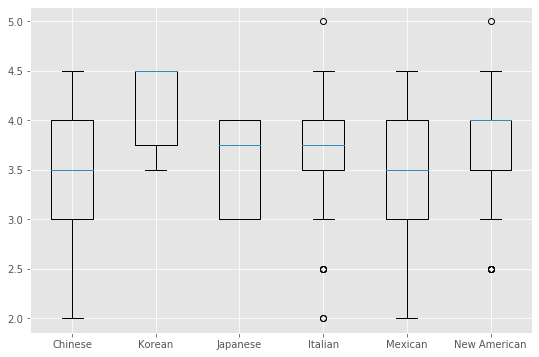

In [49]:
l_chinese = pitts_rest[pitts_rest.category == "chinese"].rating
l_korean = pitts_rest[pitts_rest.category == "korean"].rating
l_japanese = pitts_rest[pitts_rest.category == "japanese"].rating
l_italian = pitts_rest[pitts_rest.category == "italian"].rating
l_mexican = pitts_rest[pitts_rest.category == "mexican"].rating
l_newamerican = pitts_rest[pitts_rest.category == "newamerican"].rating
l = [l_chinese,l_korean,l_japanese,l_italian,l_mexican,l_newamerican]
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(l)
ax.set_xticklabels(['Chinese', 'Korean', 'Japanese', 'Italian','Mexican','New American'])

From the graph, we can see that the median of overall ratings for Korean restaurants is the highest among all six types of restaurants. We can also notice that the range of ratings for Chiense and Mexican restaurants are the largest among all six types of restaurants.

### 2. Word cloud of reviews by cuisine

### Word Cloud
A Wordcloud (or Tag cloud) is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color. 

Using wordcloud, we displayed the most frequently mentioned words in reviews of different types of restaurants.

In [ ]:
#  You can install WordCloud using `pip`:
! pip install wordcloud

In [38]:
from wordcloud import WordCloud

# categorize out reviews based on the type of the restaurant
Chinese = " ".join(pitts_review[pitts_review.type == "chinese"].text)
Korean = " ".join(pitts_review[pitts_review.type == "korean"].text)
Italian = " ".join(pitts_review[pitts_review.type == "italian"].text)
Japanese = " ".join(pitts_review[pitts_review.type == "japanese"].text)
Mexican = " ".join(pitts_review[pitts_review.type == "mexican"].text)
Newamerican = " ".join(pitts_review[pitts_review.type == "newamerican"].text)

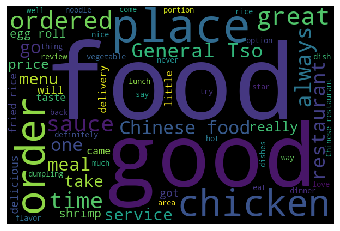

In [39]:
# generating word cloud of reviews for Chinese restaurants
Chinese_wc = WordCloud(background_color="black", width=600, height=400, max_words=60).generate(Chinese)
plt.imshow(Chinese_wc)
plt.axis("off")
plt.show()

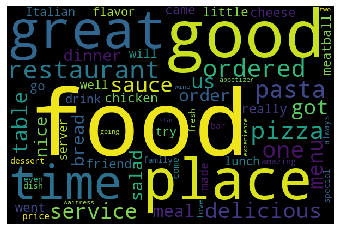

In [40]:
# generating word cloud of reviews for Italian restaurants
Italian_wc = WordCloud(background_color="black", width=600, height=400, max_words=60).generate(Italian)
plt.imshow(Italian_wc)
plt.axis("off")
plt.show()

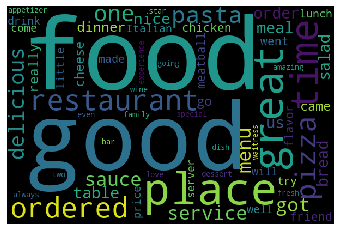

In [41]:
# generating word cloud of reviews for Italian restaurants
Italian_wc = WordCloud(background_color="black", width=600, height=400, max_words=60).generate(Italian)
plt.imshow(Italian_wc)
plt.axis("off")
plt.show()

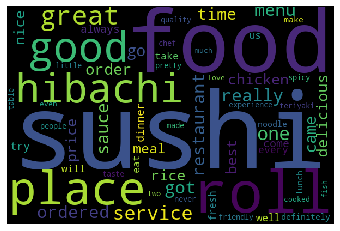

In [42]:
# generating word cloud of reviews for Japanese restaurants
Japanese_wc = WordCloud(background_color="black", width=600, height=400, max_words=60).generate(Japanese)
plt.imshow(Japanese_wc)
plt.axis("off")
plt.show()

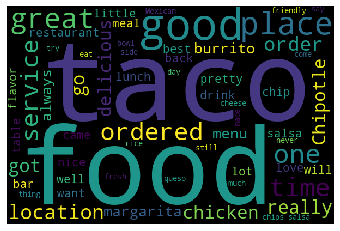

In [43]:
# generating word cloud of reviews for Mexican restaurants
Mexican_wc = WordCloud(background_color="black", width=600, height=400, max_words=60).generate(Mexican)
plt.imshow(Mexican_wc)
plt.axis("off")
plt.show()

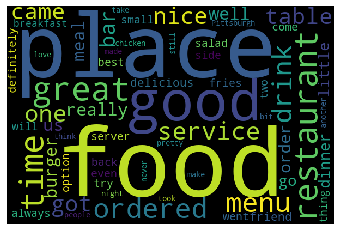

In [44]:
# generating word cloud of reviews for New American restaurants
Newamerican_wc = WordCloud(background_color="black", width=600, height=400, max_words=60).generate(Newamerican)
plt.imshow(Newamerican_wc)
plt.axis("off")
plt.show()

From the wordcloud graphs, here are the frequently mentioned words:
- Chinese: chicken, egg rolls, general Tso, shrimp, beef, noodles
- Korean: bowl, side, rice, pork, spicy, kimchi, dumplings, bulgogi
- Italian: pasta, salad, pizza, bread, meatball, cheese, chicken
- Japanese: Sushi, roll, hibachi, rice, chicken, noodles
- Mexican: taco, salsa, burrito, chip, quesadilla, cheese, margarita, fajitas, chicken
- New American: fries, burger, bar, side, sandwich, dessert, chicken, salad

## Sentimental Analysis on Reviews

When sharing their opintions on a restaurant, the Yelp user not only writes something (i.e. the review text) but also gives a rating from 1 star to 5 stars. Some people tend to write something bad but give a relative fine score while some people tend to write something good but just give a low rating. We want to explore whether this kind of tendency is the same among different cuisine categories. <b>Are people harsher to a certain cuisine?</b>

### 1. Sentimental score
To extract the feelings or emotions in the review text, we applied sentimental analysis to assign a sentimental score to each review. The sentimental score is actually the the probability that the review text is positive. We used an open Python library named `TextBlob` to help the analysis.

#### Library installation
`TextBlob` is a Natural Language Processing Python library. It is built on `nltk` and good at Sentiment Extraction with some well-trained models for use. We need install the library as well as its corpus.

In [ ]:
# install the library and its corpus
! pip install textblob
! python -m textblob.download_corpora

In [75]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

#### Example of `TextBlob`
Here is a begining sample of the sentiment extraction function of `TextBlob`. It analyzes the text and gives the probability that the text is positive or negative.

The `NaiveBayesAnalyzer` is trained on the movie reviews data from `nltk`. We chose it because of its high performance resulted from the obvious similarity between movie reviews and restaurant reviews. Behind the `NaiveBayesAnalyzer`, it tokenizes, filters, and extracts features of the words and then uses `NaiveBayesClassifier` of `nltk` to classify.

In [76]:
text = pitts_review["text"][2]
text

'This is good place to have Chinese food in this area, clean inside and excellent service. I like their duck especially!'

In [77]:
# cited from: https://textblob.readthedocs.io/en/dev/index.html#
tb = TextBlob(text, analyzer = NaiveBayesAnalyzer())
tb.sentiment

Sentiment(classification='pos', p_pos=0.9459500238217358, p_neg=0.054049976178265596)

#### `TextBlob` on review text
With `TextBlob`, we can get the sentimental scores for each review.

In [78]:
# Create two new columns for the dataframe
pitts_review["positive_score"] = 0.0
pitts_review["negative_score"] = 0.0

In [79]:
def sentimental_scores(reviews, analyzer = NaiveBayesAnalyzer()):
    """
    Calculate the probability of the text is positive or negative as the sentimental scores for each row in the reviews dataframe

    Args:
        reviews (DataFrame): reviews data, each row is a review
        analyzer: the analyzer model used by TextBlob; by default, it uses Naive Bayes Analyzer      
    Returns:
        reviews (DataFrame): to display the new dataframe which is created two new columns for positive score and negative score calculated by the model; 
    """
    for i in range(0,len(reviews)):
        # cited from: https://textblob.readthedocs.io/en/dev/index.html#
        t = TextBlob(reviews.loc[i,"text"], analyzer = analyzer)
        senti = t.sentiment
        
        reviews.loc[i,"positive_score"] = senti.p_pos
        reviews.loc[i,"negative_score"] = senti.p_neg 
    
    return reviews

In [81]:
reviews = sentimental_scores(pitts_review)
reviews

,rating,restId,text,type,positive_score,negative_score
0,5.0,JJi7c7uiTzCqeWNTsldgXQ,It's been far too long since I've come here. T...,chinese,0.999998,2.370124e-06
1,5.0,JJi7c7uiTzCqeWNTsldgXQ,My husband and I decided to give this place a ...,chinese,0.696951,3.030491e-01
2,5.0,JJi7c7uiTzCqeWNTsldgXQ,This is good place to have Chinese food in thi...,chinese,0.945950,5.404998e-02
3,4.0,JJi7c7uiTzCqeWNTsldgXQ,"Oh, maybe I ordered wrong. Or this was the mos...",chinese,0.502963,4.970375e-01
4,5.0,JJi7c7uiTzCqeWNTsldgXQ,We are new to the area and got some take out f...,chinese,0.902847,9.715285e-02
...,...,...,...,...,...,...
1547,3.0,z4EIzLJlGd7gyje1Q_hKtw,Smallman Galley is one of my favorite places i...,newamerican,1.000000,3.047489e-12
1548,5.0,z4EIzLJlGd7gyje1Q_hKtw,My husband and I love federal galley. This is ...,newamerican,0.949620,5.037985e-02
1549,5.0,z4EIzLJlGd7gyje1Q_hKtw,Great lunch visit for all to this bustling foo...,newamerican,0.992826,7.174252e-03
1550,5.0,iTonKZOZWC42LlQB77JpkA,This is a great LITTLE bar/restaurant!\n\nIt i...,newamerican,0.941640,5.836005e-02


### 2. Sentimental Score for different cuisine categories
Given the sentimental scores produced from the review texts, we can compare them among different cuisine categories and investigate whether people apply different criteria when rating.

#### Mean sentimental socres
First, we summarized the data by cuisine category and visualized the data to have a general idea.

In [82]:
meanByCate = reviews.groupby("type").mean()
meanByCate

,rating,positive_score,negative_score
type,,,
chinese,3.433846,0.767375,0.232625
italian,3.753351,0.864170,0.135830
japanese,3.812500,0.792091,0.207909
korean,4.114286,0.855282,0.144718
mexican,3.429630,0.735627,0.264373
newamerican,3.848614,0.806903,0.193097


In [83]:
# Cuisine category list
types = reviews["type"].unique().tolist()
types

['chinese', 'italian', 'japanese', 'korean', 'mexican', 'newamerican']

Text(0.5, 1.0, 'Mean for cuisine')

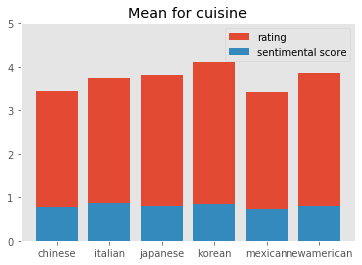

In [84]:
plt.bar(types, meanByCate['rating'])
plt.bar(types, meanByCate['positive_score'])
plt.legend(["rating", "sentimental score"], loc="best")
axes = plt.gca()
axes.set_ylim([0,5.0])
plt.grid()
plt.title("Mean for cuisine")

The plot shows that both mean rating and mean sentimental score are actually different among each cuisine category. To observe the difference better, we normalized the rating to range from 0 to 1 as well so that we can compare the normalized rating with the sentimental score directlt.

Text(0.5, 1.0, 'Difference between normalized rating and sentimental score')

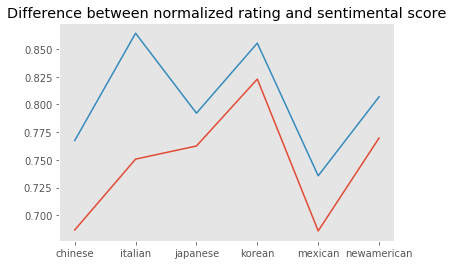

In [85]:
norm = meanByCate.copy()
norm['rating'] = norm['rating']/5

plt.plot(norm[['rating','positive_score']])
plt.grid()
plt.title("Difference between normalized rating and sentimental score")

From the visualization, we've noticed that some difference gaps are huge while some are small.

#### Hypothesis testing
In addition to the visualization, we also performed the hypothesis testing on whether there the difference among cuisine categories are significant. We first built the regression predicting the rating by the sentimental score for each cuisine category and then tested whether regression models are same by testing their slope coefficients.

##### Regression
We built the regression and got the slope with its standard errors for each cuisine category.

In [86]:
def regression(types, reviews):
    """
    Build regression predicting rating scores on sentimental scores produced by review text analysis
    
    Args:
        types (list): list of cuisine category
        reviews (DataFrame): reviews data, each row is a review    
    Returns:
        slopes (Dictionary): key is cuisine category, value is slope coefficient of the regression for each cuisine category
        std_errs (Dictionary): key is cuisine category, value is standrad errors of the slope coefficient of the regression for each cuisine category
    """
    slopes = {}
    std_errs = {}
    for i in range(0,len(types)):
        slope, intercept, r_value, p_value, std_err = stats.linregress(reviews[reviews["type"]==types[i]]["positive_score"],reviews[reviews["type"]==types[i]]["rating"])
        slopes[types[i]] = slope
        std_errs[types[i]] = std_err
    return (slopes, std_errs)

In [87]:
slopes, std_errs = regression(types, reviews)
slopes, std_errs

({'chinese': 2.110771788123103,
  'italian': 1.7217859374529048,
  'japanese': 1.2788598473347195,
  'korean': 1.199268361690619,
  'mexican': 1.7668827921561852,
  'newamerican': 1.2677619068041495},
 {'chinese': 0.23258445891059815,
  'italian': 0.26690109773999804,
  'japanese': 0.4588331840417963,
  'korean': 0.5420079415959076,
  'mexican': 0.21286559990583956,
  'newamerican': 0.17233371252499435})

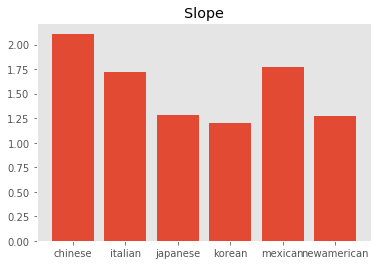

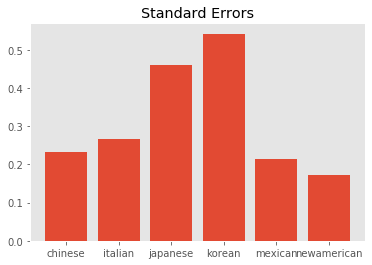

In [88]:
plt.bar(*zip(*sorted(slopes.items())))
plt.grid()
plt.title("Slope")
plt.show()
plt.bar(*zip(*sorted(std_errs.items())))
plt.grid()
plt.title("Standard Errors")
plt.show()

From the visualization, we've found the slopes are quite different in some pairs.

##### [Hypothesis testing](https://stats.stackexchange.com/questions/93540/testing-equality-of-coefficients-from-two-different-regressions)
To test equality of slopes from two different regressions, Z-test is used. The formula is as below:
$$\text{Z}= \frac{\beta_{1} - \beta_{2}} {\text{SE}\beta_{1} - \text{SE}\beta_{2}} $$ 
Where $\text{SE}\beta$ is the standard error of $\beta$.

In [89]:
def hypothesis_testing(types, slopes, std_errs):
    """
    Perform hypothesis testing on each pairs of regreesion models to test whether two models have the same coefficient.
    
    Args:
        types (list): list of cuisine category
        slopes (Dictionary): key is cuisine category, value is slope coefficient of the regression for each cuisine category
        std_errs (Dictionary): key is cuisine category, value is standrad errors of the slope coefficient of the regression for each cuisine category
    Returns:
        zs (Dictionary): key is the pair of two cuisine category, value is the z-test value and whether to reject the hypothesis
    """
    zs = {}
    for i in range(0,len(types)):
        for j in range(i+1,len(types)):
            z = (slopes[types[i]] - slopes[types[j]]) / math.sqrt(std_errs[types[i]]**2 + std_errs[types[j]]**2)
            rej = z > 1.65
            zs[types[i]+" & "+types[j]] = (z, rej)
    return zs

In [90]:
zs = hypothesis_testing(types, slopes, std_errs)
zs

{'chinese & italian': (1.0987611444179142, False),
 'chinese & japanese': (1.6171980831638717, False),
 'chinese & korean': (1.5454358355991138, False),
 'chinese & mexican': (1.0907096432836478, False),
 'chinese & newamerican': (2.9122259428989454, True),
 'italian & japanese': (0.8344271834918732, False),
 'italian & korean': (0.8648668138680672, False),
 'italian & mexican': (-0.13209729226894856, False),
 'italian & newamerican': (1.4290838834652329, False),
 'japanese & korean': (0.11207839732447943, False),
 'japanese & mexican': (-0.9648422468349488, False),
 'japanese & newamerican': (0.022642880047275868, False),
 'korean & mexican': (-0.9747641330072553, False),
 'korean & newamerican': (-0.12042915036094734, False),
 'mexican & newamerican': (1.8224021311381884, True)}

There are two pairs of testing produced the "rejection" result, which means the coefficients for Chinese and New American cuisines and the coefficients for Mexican and New American cuisines have significantly difference.

### 3. Conclusion

The larger slope coefficient means people say something not that good but still give high rating. People are more generous in this way! The result shows people are harsher to New American cuisine than Chinese cuisine and Mexican cuisine! 

According to the [Quantcast country demographics](https://www.quora.com/Is-Yelp-big-in-any-other-countries), the top 2 countries where Yelp users are from is US and Canada. Noted that over 50% Yelp users are from US or Canada, We believe that people tend to have higher criteria for cuisine from their own culture! 

## Restaurant Popularity: Number of Reviews

Using the restaurants dataset, we want to look at the distribution of number of reviews across the six types of restaurants.

### 1. Number of reviews vs type of restaurants

[Text(0, 0, 'Chinese'),
 Text(0, 0, 'Korean'),
 Text(0, 0, 'Japanese'),
 Text(0, 0, 'Italian'),
 Text(0, 0, 'Mexican'),
 Text(0, 0, 'New American')]

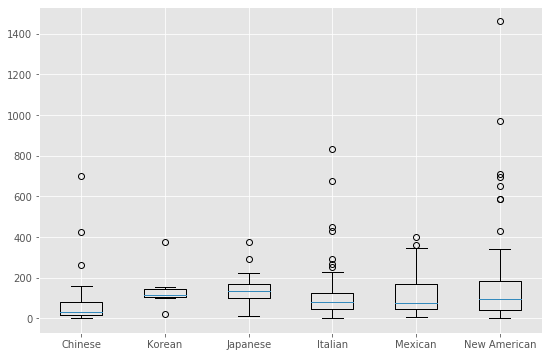

In [72]:
# plot review count vs type of restaurants
l_chinese = pitts_rest[pitts_rest.category == "chinese"].review_count
l_korean = pitts_rest[pitts_rest.category == "korean"].review_count
l_japanese = pitts_rest[pitts_rest.category == "japanese"].review_count
l_italian = pitts_rest[pitts_rest.category == "italian"].review_count
l_mexican = pitts_rest[pitts_rest.category == "mexican"].review_count
l_newamerican = pitts_rest[pitts_rest.category == "newamerican"].review_count
l = [l_chinese,l_korean,l_japanese,l_italian,l_mexican,l_newamerican]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(l)
ax.set_xticklabels(['Chinese', 'Korean', 'Japanese', 'Italian','Mexican','New American'])

From the graph, we can see that Korean and Japanese restaurants have the highest median of number of reviews among the six types of restaurants. We can also notice that New American restaurants have the biggest range of number of reviews compared to the other five types of restaurants.

### 2. Number of Reviews vs overall rating of restaurants

In [91]:
# Compute the correlation between review count and overall rating of the restaurant.
np.corrcoef(pitts_rest["rating"], pitts_rest["review_count"])

array([[1.        , 0.06639637],
       [0.06639637, 1.        ]])

Since the correlation coefficient is close to 0, we say that there is very little correlation between the overall restaurant rating and the number of reviews for that restaurant.

### 3. Demographics variables
Next, we incorported some demographics variables from Policymap and investigate their relationships with the average number of reviews of restaurants in a zip code area.

The demographics variables we used are:
- Population Density
- Chinese population percentage
- White population percentage

#### 3.1 Average number of reviews vs population density of zip code area

`pop_den`: [population_density.csv](https://drive.google.com/open?id=1GrSFGARSOdkbgrlqswm9INzSpN7OFic_): Estimated number of people per square mile, between 2013-2017, by zip code. source: [Policymap](http://www.policymap.com/our-data-directory.html#Census:%20Decennial%20Census%20and%20American%20Community%20Survey%20(ACS)!)

In [93]:
pop_den = pd.read_csv("population_density.csv")
pop_den['zipcode']=pop_den['zipcode'].astype(int)
pop_den['num_pp_per_sq_mile']=pop_den['num_pp_per_sq_mile'].astype(float)
pop_den.head()

,zipcode,num_pp_per_sq_mile
0,16720,3.97
1,16735,21.35
2,16915,24.81
3,16901,43.30
4,16701,81.15


Map each restaurant in `rest` with a population density in `pop_den` using the zip code of the restaurant.

In [95]:
## append population density to rest and remove rows containing NAs
full= pd.merge(left = pitts_rest, right = pop_den, how = "left", left_on = "zipcode", right_on = "zipcode")
full= full.dropna()
full.head()

,address,category,name,rating,restId,review_count,url,zipcode,num_pp_per_sq_mile
0,4502 Butler St,vietnamese,Banh Mi & Ti,4.5,4mYS-4UOjTKgsf0tX1_IkQ,250.0,https://www.yelp.com/biz/banh-mi-and-ti-pittsb...,15201,5158.58
1,5202 Butler St,coffee,B52 Cafe,4.5,bXCWON2Me0o86qvAb-XZPQ,258.0,https://www.yelp.com/biz/b52-cafe-pittsburgh-4...,15201,5158.58
2,3623 Butler St,coffee,Espresso a Mano,4.5,Cf0iV72DTqR0ggBje2d0sg,337.0,https://www.yelp.com/biz/espresso-a-mano-pitts...,15201,5158.58
3,4121 Butler St,creperies,Geppetto Cafe,4.5,FG8atOE15c8IoQH_hEb9zA,242.0,https://www.yelp.com/biz/geppetto-cafe-pittsbu...,15201,5158.58
4,3801 Butler St,italian,Piccolo Forno,4.0,usFNFsaaHFxEbnBO4FaFHA,447.0,https://www.yelp.com/biz/piccolo-forno-pittsbu...,15201,5158.58


In [97]:
# Calculate the mean of number of reviews of restaurants in a neighborhood.
df = full[['zipcode','review_count','num_pp_per_sq_mile']]
df = df.groupby(['zipcode']).mean()
df.head()

,review_count,num_pp_per_sq_mile
zipcode,,
15201,131.888889,5158.58
15202,34.347826,4443.36
15203,112.346457,6883.83
15205,98.923077,2174.42
15206,139.088608,6188.66


In [98]:
# compute correlation coefficient between population density and review count
np.corrcoef(df["num_pp_per_sq_mile"], df["review_count"])

array([[1.       , 0.4781326],
       [0.4781326, 1.       ]])

Since the correlation coefficient is about 0.5, we can say that there is a moderate correlation between population density of a neighborhood and the average number of reviews of restaurants in that neighborhood. This can also be reflected in an upward trend in the scatterplot below.

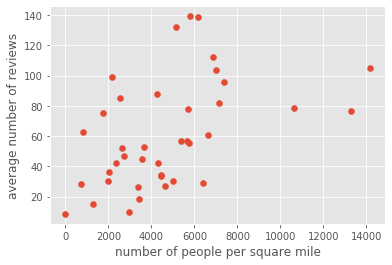

In [99]:
# plot review count vs population density
plt.scatter(df["num_pp_per_sq_mile"],df["review_count"] )
plt.xlabel("number of people per square mile")
plt.ylabel("average number of reviews")
plt.show()

#### 3.2 Average number of reviews vs median household income of zip code area

`income` : [median_household_income.csv](https://drive.google.com/open?id=1ONI5wKC16BPRzlBd0eUYOlZyLSBLNSNB): Median household income, between 2013-20, by zip code. source: [Policymap](http://www.policymap.com/our-data-directory.html#Census:%20Decennial%20Census%20and%20American%20Community%20Survey%20(ACS)) 
)

`income_zip` : mapping each restaurant in `rest` with a median household income in `income` using the zip code of the restaurant.

In [100]:
income = pd.read_csv("median_income_household.csv")
income['zipcode']=income['zipcode'].astype(int)
income['median_income_household']= income['median_income_household'].astype(float)
income.head()

,zipcode,median_income_household
0,16720,47109.0
1,16735,45741.0
2,16915,47804.0
3,16901,53809.0
4,16701,42825.0


In [101]:
income_zip = pd.merge(left = pitts_rest, right = income, how = "left", left_on = "zipcode", right_on = "zipcode")
income_zip = income_zip.dropna()
income_zip.head()

,address,category,name,rating,restId,review_count,url,zipcode,median_income_household
0,4502 Butler St,vietnamese,Banh Mi & Ti,4.5,4mYS-4UOjTKgsf0tX1_IkQ,250.0,https://www.yelp.com/biz/banh-mi-and-ti-pittsb...,15201,56897.0
1,5202 Butler St,coffee,B52 Cafe,4.5,bXCWON2Me0o86qvAb-XZPQ,258.0,https://www.yelp.com/biz/b52-cafe-pittsburgh-4...,15201,56897.0
2,3623 Butler St,coffee,Espresso a Mano,4.5,Cf0iV72DTqR0ggBje2d0sg,337.0,https://www.yelp.com/biz/espresso-a-mano-pitts...,15201,56897.0
3,4121 Butler St,creperies,Geppetto Cafe,4.5,FG8atOE15c8IoQH_hEb9zA,242.0,https://www.yelp.com/biz/geppetto-cafe-pittsbu...,15201,56897.0
4,3801 Butler St,italian,Piccolo Forno,4.0,usFNFsaaHFxEbnBO4FaFHA,447.0,https://www.yelp.com/biz/piccolo-forno-pittsbu...,15201,56897.0


In [103]:
# Plot review_count vs median income of household in pittsburgh area
df = income_zip[['zipcode','review_count','median_income_household']]
df = df.groupby(['zipcode']).mean()
df.head()

,review_count,median_income_household
zipcode,,
15201,131.888889,56897.0
15202,34.347826,48363.0
15203,112.346457,51306.0
15205,98.923077,55115.0
15206,139.088608,41899.0


In [104]:
# Compute correlation coefficient between population density and review count
np.corrcoef(df["median_income_household"], df["review_count"])

array([[ 1.        , -0.00982306],
       [-0.00982306,  1.        ]])

Since the correlation coefficient is close to 0, we say that there is very little correlation between the average number of reviews of restaurants in a neighborhood and the median household income of that neighborhood.

#### 3.3 Average number of reviews of Chinese restaurants vs <br>Chinese population percentage of zip code area

`chinesepop`: [chinesepop.csv](https://drive.google.com/open?id=1gXx3T1ukyDTyp-rwEuyAjS_vIp3F-3zf): Chinese population percentage, between 2013-17, by zip code. source: [Policymap](https://www.policymap.com/data/our-data-directory/#Census:%20Decennial%20Census%20and%20American%20Community%20Survey%20(ACS)) 

In [120]:
chinesepop = pd.read_csv("chinesepop.csv")
chinesepop['zipcode']=chinesepop['zipcode'].astype(int)
chinesepop['percentage_chinese']=chinesepop['percentage_chinese'].astype(float)
chinesepop.head()

,zipcode,percentage_chinese
0,15212,0.50
1,15207,0.53
2,15206,2.25
3,15210,0.24
4,15214,0.29


`chinese_rest`: map each restaurant in `rest` with a Chinese population percentage in `chinesepop` using the zip code of the restaurant.

In [121]:
chinese_rest= pd.merge(left = pitts_rest, right = chinesepop, how = "left", left_on = "zipcode", right_on = "zipcode")
chinese_rest= chinese_rest.dropna()
chinese_rest = chinese_rest[chinese_rest.category == "chinese"]
chinese_rest.head()

,address,category,name,rating,restId,review_count,url,zipcode,percentage_chinese
51,5100 Butler St,chinese,Zen Asian Diner,3.0,afdthOntL8hfhomIFX-NWg,89.0,https://www.yelp.com/biz/zen-asian-diner-pitts...,15201,0.14
62,5500 Butler St,chinese,China Lin,3.5,toc31C-Qy2smSq0A7Q8FgA,35.0,https://www.yelp.com/biz/china-lin-pittsburgh?...,15201,0.14
78,472 44th St,chinese,Forever Rosemary,2.0,o2UAUbXSNRrqleXtSMLniA,4.0,https://www.yelp.com/biz/forever-rosemary-pitt...,15201,0.14
246,2013 Wharton St,chinese,Chan An Restaurant,3.0,gz87Wa7QUZ3gNlgE9NVPAA,8.0,https://www.yelp.com/biz/chan-an-restaurant-pi...,15203,0.34
368,213 S Highland Ave,chinese,Red Dragon,4.0,IcrFc5IwCcKyGbVmgWjVjg,25.0,https://www.yelp.com/biz/red-dragon-pittsburgh...,15206,2.25


In [122]:
# Compute the mean of review counts of Chinese restaurants for each neighborhood.
chinese_rest = chinese_rest[['zipcode','review_count','percentage_chinese']]
chinese_rest = chinese_rest.groupby(['zipcode']).mean()
chinese_rest

,review_count,percentage_chinese
zipcode,,
15201,42.666667,0.14
15203,8.000000,0.34
15206,24.000000,2.25
15210,14.000000,0.24
15211,86.000000,0.70
15212,21.000000,0.50
15213,99.875000,8.54
15216,40.000000,0.35
15217,184.714286,4.75


In [110]:
# Compute the correlation between Chinese population percentage and average review count of Chinese restaurants.
np.corrcoef(chinese_rest["percentage_chinese"], chinese_rest["review_count"])

array([[1.        , 0.53337634],
       [0.53337634, 1.        ]])

Since the correlation coefficient is about 0.5, we can say there is a moderate correlation between the average number of reviews of Chinese restaurants in a neighborhood and the percentage of Chinese population in that neighborhood. This can also be reflected in the slight upward trend in the scatterplot below.

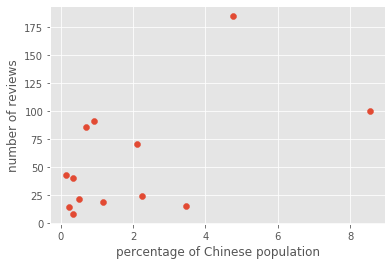

In [111]:
plt.scatter(chinese_rest["percentage_chinese"],chinese_rest["review_count"] )
plt.xlabel("percentage of Chinese population")
plt.ylabel("number of reviews")
plt.show()

#### 3.4 Average number of reviews of Traditional American restaurants vs <br>white population percentage of zip code area

`whitepop`: [whitepop.csv](https://drive.google.com/open?id=1ZNhII6nny93nQ4kh6NfvIuwW2wf3JRHT): white population percentage, between 2013-17, by zip code. source: [Policymap](https://www.policymap.com/data/our-data-directory/#Census:%20Decennial%20Census%20and%20American%20Community%20Survey%20(ACS))

`white_rest`: mapping each restaurant in `rest` with a white population percentage in `whitepop` using the zip code of the restaurant.

In [112]:
whitepop = pd.read_csv("whitepop.csv")
whitepop['zipcode']=whitepop['zipcode'].astype(int)
whitepop['percent_white']=whitepop['percent_white'].astype(float)
whitepop.head()

,zipcode,percent_white
0,15212,67.30
1,15207,79.50
2,15206,52.27
3,15210,61.65
4,15214,58.14


In [114]:
white_rest= pd.merge(left = pitts_rest, right = whitepop, how = "left", left_on = "zipcode", right_on = "zipcode")
white_rest= white_rest.dropna()
white_rest = white_rest[white_rest.category == "tradamerican"]
white_rest.head()

,address,category,name,rating,restId,review_count,url,zipcode,percent_white
42,4901 Hatfield St,tradamerican,Stinky's Bar & Grill,4.0,TWk7hL6yCx5mYcs0Ys-usQ,66.0,https://www.yelp.com/biz/stinkys-bar-and-grill...,15201,74.79
127,1805 E Carson St,tradamerican,Fat Heads Saloon,4.0,LQFmktF43j2NPncKdNd9mg,787.0,https://www.yelp.com/biz/fat-heads-saloon-pitt...,15203,91.25
148,2316 E Carson St,tradamerican,The Pretzel Shop,4.5,aDHD7nASfqiQBB6YXy2aGA,109.0,https://www.yelp.com/biz/the-pretzel-shop-pitt...,15203,91.25
163,2339 E Carson St,tradamerican,Double Wide Grill,3.0,aY8xiGLpTjIkz6FAJbCy7A,494.0,https://www.yelp.com/biz/double-wide-grill-pit...,15203,91.25
173,1327 E Carson St,tradamerican,The Vault Taproom,4.5,u8pWT0002q-Y9GvrUwVFVw,54.0,https://www.yelp.com/biz/the-vault-taproom-pit...,15203,91.25


In [115]:
# Compute the mean of review counts of traditional American restaurants for each neighborhood.
white_rest = white_rest[['zipcode','review_count','percent_white']]
white_rest = white_rest.groupby(['zipcode']).mean()
white_rest

,review_count,percent_white
zipcode,,
15201,66.000000,74.79
15203,251.714286,91.25
15206,15.000000,52.27
15207,216.000000,79.50
15208,2.000000,32.52
15210,38.000000,61.65
15211,219.000000,87.55
15212,141.000000,67.30
15213,192.000000,67.93


In [116]:
# Compute the correlation between white population percentage and average review count of traditional American restaurants.
np.corrcoef(white_rest["percent_white"], white_rest["review_count"])

array([[1.        , 0.70824471],
       [0.70824471, 1.        ]])

Since the correlation coefficient is about 0.71, we can say there is a strong correlation between the average number of reviews of traditional American restaurants in a neighborhood and the percentage of white population in that neighborhood. This can also be reflected in the obvious upward trend in the scatterplot below.

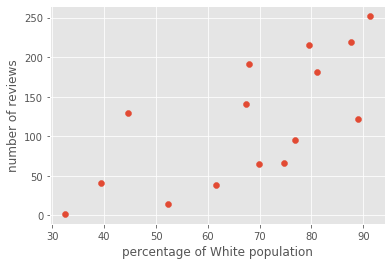

In [117]:
plt.scatter(white_rest["percent_white"],white_rest["review_count"])
plt.xlabel("percentage of White population")
plt.ylabel("number of reviews")
plt.show()

## Recommendations
Business Owner:<br>
1. The frequently mentioned items in the word cloud graphs can be considered as popular dishes for different cuisines. Restaurant owners can refer to a specific cuisine to decide what to offer in their restaurant.
2. Traditional American restuarants should choose neighborhoods with high White population percentage
3. Chinese restaurants should choose the neighborhood with high Chinese population percentage.

Yelp user:
1. The Yelp user can realize that the ratings for different cuisine categories may be different and may not compare the absolute values in the direct way. 
2. It would be great if the user can read more review contents to make the decision rather than just the rating stars. Other people may not have the same rating criteria with you, but the review content tells the truth!


## Future Directions
1. This projet only gather the data including six types of restaurants from Pittsburgh area. In the future, we could test our hypothesis on more data from other parts of the U.S and incorporate other types of restaurants.
2. Number of reviews (cumulative) may be affected by the age of the restaurant. Hence, we need to find a better variable to capture the popularity of the restaurants. 

## References

Yelp Fusion API: https://www.yelp.com/fusion<br>
fake-useragent 0.1.11: https://pypi.org/project/fake-useragent/<br>
TextBlob: https://www.datasciencelearner.com/sentiment-analysis-python-library-textblob/ <br>
TextBlob: https://textblob.readthedocs.io/en/dev/index.html#<br>
TextBlob Naive Bayes Analyzer source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html<br>
Hypothesis Testing: https://stats.stackexchange.com/questions/93540/testing-equality-of-coefficients-from-two-different-regressions<br>
Yelp user: https://www.quora.com/Is-Yelp-big-in-any-other-countries